# How to Create an N-Gram Model from Scratch

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

## Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by exponentiating mean information. 

# Set Up Environment

In [1]:
import pandas as pd
import numpy as np

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [3]:
output_dir

'/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output'

In [4]:
ngrams = 3
widx = [f"w{i}" for i in range(ngrams)]

In [5]:
widx

['w0', 'w1', 'w2']

# Get Some Training Data

In [6]:
data_dir = output_dir
OHCO = ['book_id','chap_num','para_num','sent_num','token_num']

In [7]:
TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
VOCAB = pd.read_csv(data_dir + "/austen-combo-VOCAB.csv").set_index('term_str')

In [8]:
TOKEN.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0               Sir       sir
                                   1            Walter    walter
                                   2            Elliot    elliot
                                   3                of        of
                                   4          Kellynch  kellynch

In [9]:
VOCAB.head()

,n
term_str,
1,3
15,1
16,1
1760,1
1784,1


# Select OOV terms

For our OOV terms, we select very short words that appear only once.

This is just one way to handle OOV terms.

In [10]:
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['modified_term_str'] = VOCAB.index
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modified_term_str'] = "<UNK>"

In [11]:
VOCAB

,n,n_chars,modified_term_str
term_str,,,
1,3,1,1
15,1,2,<UNK>
16,1,2,<UNK>
1760,1,4,1760
1784,1,4,1784
...,...,...,...
youthful,3,8,youthful
z,1,1,<UNK>
zeal,7,4,zeal


We apply the modified term list to our tokens.

In [12]:
TOKEN['modified_term_str'] = TOKEN.term_str.map(VOCAB.modified_term_str)

In [13]:
TOKEN[TOKEN.modified_term_str == '<UNK>'].sample(5)

token_str term_str  \
book_id chap_num para_num sent_num token_num                      
1       22       41       2        1                 n        n   
2       39       19       13       11                L        l   
1       1        2        4        3                20       20   
                 18       1        8                 Z        z   
2       25       2        2        23               ve       ve   

                                             modified_term_str  
book_id chap_num para_num sent_num token_num                    
1       22       41       2        1                     <UNK>  
2       39       19       13       11                    <UNK>  
1       1        2        4        3                     <UNK>  
                 18       1        8                     <UNK>  
2       25       2        2        23                    <UNK>

# Generate NGram Models

Here, we want to take our list of modified tokens and add sentence boundary symbols `<s>` and `</s>` before and after each sentence.

Then we want to bind offset versions of the this token list into a dataframe with as many columns as our ngram is wide.

So, for example, for a trigram table representing the novle _Emma_, we want something like this:

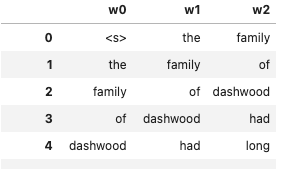

Note how each succussive column is the same data but shifted up one row.

Note also that this table contains all the data required to count instances of trigrams and all lower-order n-grams, i.e. bigram and unigram.

## Prepare tokens for ngram binding

We assign an absolute sentence number to each inital token and then label all the tokens in a given sentence by their sentence number.

We must do this because the current `sent_num` index column refers to the order of the sentence within the paragraph.

We want the order of the sentence within the corpus.

In [14]:
def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    padded.index.names = ohco
    return padded

In [15]:
PADDED = token_to_padded(TOKEN, grouper=OHCO[:4], term_str='modified_term_str')

In [16]:
PADDED.head()

term_str
book_id chap_num para_num sent_num token_num         
1       1        0        0        0              <s>
                                   1              sir
                                   2           walter
                                   3           elliot
                                   4               of

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

Now we concatenate a set of offset versions of our token list. 

We use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

Then we use the `pd.concat()` method to bind our offset token lists.

In [17]:
# T = PADDED.groupby(OHCO[:4]).apply(lambda x: pd.concat([x.shift(0-i) for i in range(ngrams)], axis=1)).reset_index(drop=True)
# T.index = PADDED.index
# T.columns = widx

In [18]:
# T.loc[(1,1,0,2)]

In [19]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):
    
    ohco = padded.index.names
    ngrams = padded.groupby(grouper).apply(lambda x: pd.concat([x.shift(0-i) for i in range(n)], axis=1)).reset_index(drop=True)
    ngrams.index = padded.index
    ngrams.columns = widx

    # ngrams = pd.concat([padded.shift(0-i) for i in range(n)], axis=1)
    # ngrams.index.name = 'ngram_num'
    # ngrams.columns = widx
    # ngrams = ngrams.fillna('<EOF>')
    
    return ngrams

In [20]:
NGRAMS = padded_to_ngrams(PADDED, OHCO[:4], ngrams)

In [21]:
NGRAMS

w0        w1        w2
book_id chap_num para_num sent_num token_num                                 
1       1        0        0        0                  <s>       sir    walter
                                   1                  sir    walter    elliot
                                   2               walter    elliot        of
                                   3               elliot        of  kellynch
                                   4                   of  kellynch      hall
...                                                   ...       ...       ...
2       50       23       0        10         sensibility        by      jane
                                   11                  by      jane    austen
                                   12                jane    austen      </s>
                                   13              austen      </s>      None
                                   14                </s>      None      None

[232051 rows x 3 columns]

## Generate models

Next we create a list of models. 

Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. 

We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [100]:
def ngrams_to_models(ngrams, k=.01):
    global widx
    n = len(ngrams.columns)
    model = [None for i in range(n)]
    for i in range(n):
        if i == 0:
            model[i] = ngrams.value_counts('w0').to_frame('n')
            model[i]['p'] = model[i].n / model[i].n.sum()
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams.value_counts(widx[:i+1]).to_frame('n')    
            model[i]['cp'] = model[i].n / model[i-1].n
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
    return model

In [101]:
M = ngrams_to_models(NGRAMS)

In [105]:
M[1]

n        cp         i
w0        w1                                
1         1760         1  0.333333  1.584963
          1785         1  0.333333  1.584963
          ends         1  0.333333  1.584963
1760      married      1  1.000000  0.000000
1784      elizabeth    1  1.000000  0.000000
...                   ..       ...       ...
zealous   attention    1  0.250000  2.000000
          officer      1  0.250000  2.000000
          on           1  0.250000  2.000000
zealously active       1  0.500000  1.000000
          discharging  1  0.500000  1.000000

[78270 rows x 3 columns]

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [57]:
def sentence_to_token(sent_list, file=True):
    
    # Convert list of sentences to dataframe
    if file:
        S = pd.read_csv("test_sentences.txt", header=None, names=['sent_str'])
    else:
        S = pd.DataFrame(sent_list, columns=['sent_str'])
    S.index.name = 'sent_num'
    
    # Convert dataframe of sentences to TOKEN with normalized terms
    K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
    K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
    K.index.names = ['sent_num', 'token_num']
    
    return S, K

In [58]:
TEST_SENTS, TEST_TOKENS = sentence_to_token("test_sentences.txt")

In [59]:
TEST_SENTS.head()

,sent_str
sent_num,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,ChatGPT is not the singularity
4,but it was a black morning's work for her


In [60]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               the      the
         1             quick    quick
         2             brown    brown
         3               fox      fox
         4            jumped   jumped

## Identify OOV terms

Create a Series of OOV terms from our unigram model.

This could be included in our function.

In [61]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(M[0].index), 'term_str'] = "<UNK>"

In [62]:
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

token_str
Weston            2
ChatGPT           1
Hartfield         1
Isabella          1
Isabella's        1
Woodhouse         1
childhood         1
illnesses         1
intellectual      1
lazy              1
tenderer          1
valetudinarian    1
Name: count, dtype: int64

## Convert test tokens into ngrams

Use offset and bind method using `pd.concat()` and `df.shift(0)`, as above.

In [63]:
TEST_PADDED = token_to_padded(TEST_TOKENS)

In [64]:
TEST_PADDED.head()

term_str
sent_num token_num         
0        0              <s>
         1              the
         2            quick
         3            brown
         4              fox

In [65]:
TEST_NGRAMS = padded_to_ngrams(TEST_PADDED, 'sent_num', ngrams)

In [66]:
TEST_NGRAMS.loc[0]

,w0,w1,w2
token_num,,,
0,<s>,the,quick
1,the,quick,brown
2,quick,brown,fox
3,brown,fox,jumped
4,fox,jumped,over
5,jumped,over,the
6,over,the,<UNK>
7,the,<UNK>,dogs
8,<UNK>,dogs,</s>


## Bind the models to test data

We add our model data to the test data as a set of features.

In [67]:
def test_model(model, ngrams, sents):
    
    global widx
    
    assert len(model) == len(ngrams.columns)
    
    n = len(model)
    ohco = ngrams.index.names
    
    R = []
    for i in range(n):
        T = ngrams.merge(M[i], on=widx[:i+1], how='left')
        T.index = ngrams.index
        T = T.reset_index().set_index(ohco + widx).i #.to_frame(f"i{i}")
        
        # This how we handle unseen combos
        T[T.isna()] = T.max()
        R.append(T.to_frame(f"i{i}"))
                
    return pd.concat(R, axis=1)

In [68]:
R = test_model(M,TEST_NGRAMS, TEST_SENTS)

In [69]:
R

i0         i1         i2
sent_num token_num w0       w1       w2                                      
0        0         <s>      the      quick     4.104468   4.952406  28.989955
         1         the      quick    brown     4.978319  13.237646  28.989955
         2         quick    brown    fox      13.589751  13.237646  28.989955
         3         brown    fox      jumped   15.834835  13.237646  28.989955
         4         fox      jumped   over     17.824082  13.237646  28.989955
...                                                 ...        ...        ...
42       11        her      pleasant society   5.966914  13.237646  28.989955
         12        pleasant society  again    13.030568  13.237646  28.989955
         13        society  again    </s>     12.628594  13.237646  28.989955
         14        again    </s>     NaN       9.714265   4.951535  28.989955
         15        </s>     NaN      NaN       4.104468  13.237646  28.989955

[522 rows x 3 columns]

In [70]:
def compute_perplexity(results, test_sents, n=3):
    for i in range(n):
        test_sents[f"pp{i}"] = np.exp2(results.groupby('sent_num')[f"i{i}"].mean())
    return test_sents

In [71]:
PP = compute_perplexity(R, TEST_SENTS)

In [72]:
PP.sort_values('pp0')

,sent_str,pp0,pp1,pp2
sent_num,,,,
28,but he was no companion for her,121.684065,143.789682,1.967799e+08
20,How was she to bear the change,143.174095,705.529866,3.874804e+08
24,and a Miss Taylor in the house,169.463176,381.865321,2.189530e+08
15,knowing all the ways of the family,202.585766,508.329765,3.121303e+08
1,The event had every promise of happiness for h...,235.702669,620.168741,4.596415e+08
11,but the intercourse of the last seven years,247.654829,405.330102,2.967378e+08
33,for having been a valetudinarian all his life,247.872617,468.541793,4.335868e+08
25,and with all her advantages natural and domestic,255.775900,1043.362548,2.889590e+08
19,and who had such an affection for her as could...,268.413488,347.574231,3.497075e+08


In [40]:
# T0 = TEST_NGRAMS.merge(M[0], on=['w0'], how='left')
# T0.index = TEST_NGRAMS.index
# TEST_SENTS['pp0'] = np.exp2(T0.groupby('sent_num').i.mean())

# T1 = TEST_NGRAMS.merge(M[1], on=['w0','w1'], how='left')
# T1.index = TEST_NGRAMS.index
# TEST_SENTS['pp1']= np.exp2(T1.groupby('sent_num').ci.mean())

# T2 = TEST_NGRAMS.merge(M[2], on=['w0','w1','w2'], how='left')
# T2.index = TEST_NGRAMS.index
# TEST_SENTS['pp2']= np.exp2(T2.groupby('sent_num').ci.mean())

# Model Perplexity

In [41]:
# R.groupby('sent_num').mean().mean().plot.bar();

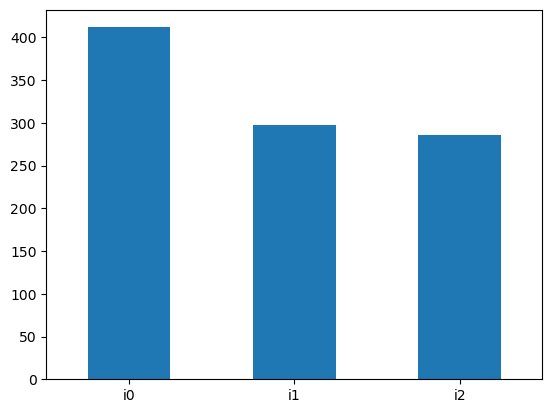

In [42]:
np.exp2(R.mean()).plot.bar(rot=0);

In [43]:
PP.iloc[:,1:].corr().style.background_gradient(axis=None)

,pp0,pp1,pp2
pp0,1.000000,0.798902,0.595819
pp1,0.798902,1.000000,0.629656
pp2,0.595819,0.629656,1.000000


In [44]:
# PP.iloc[:,1:].corr().unstack().sort_values(ascending=False).reset_index().query("level_0 < level_1").set_index(['level_0','level_1'])

# Visualize

In [45]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [46]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

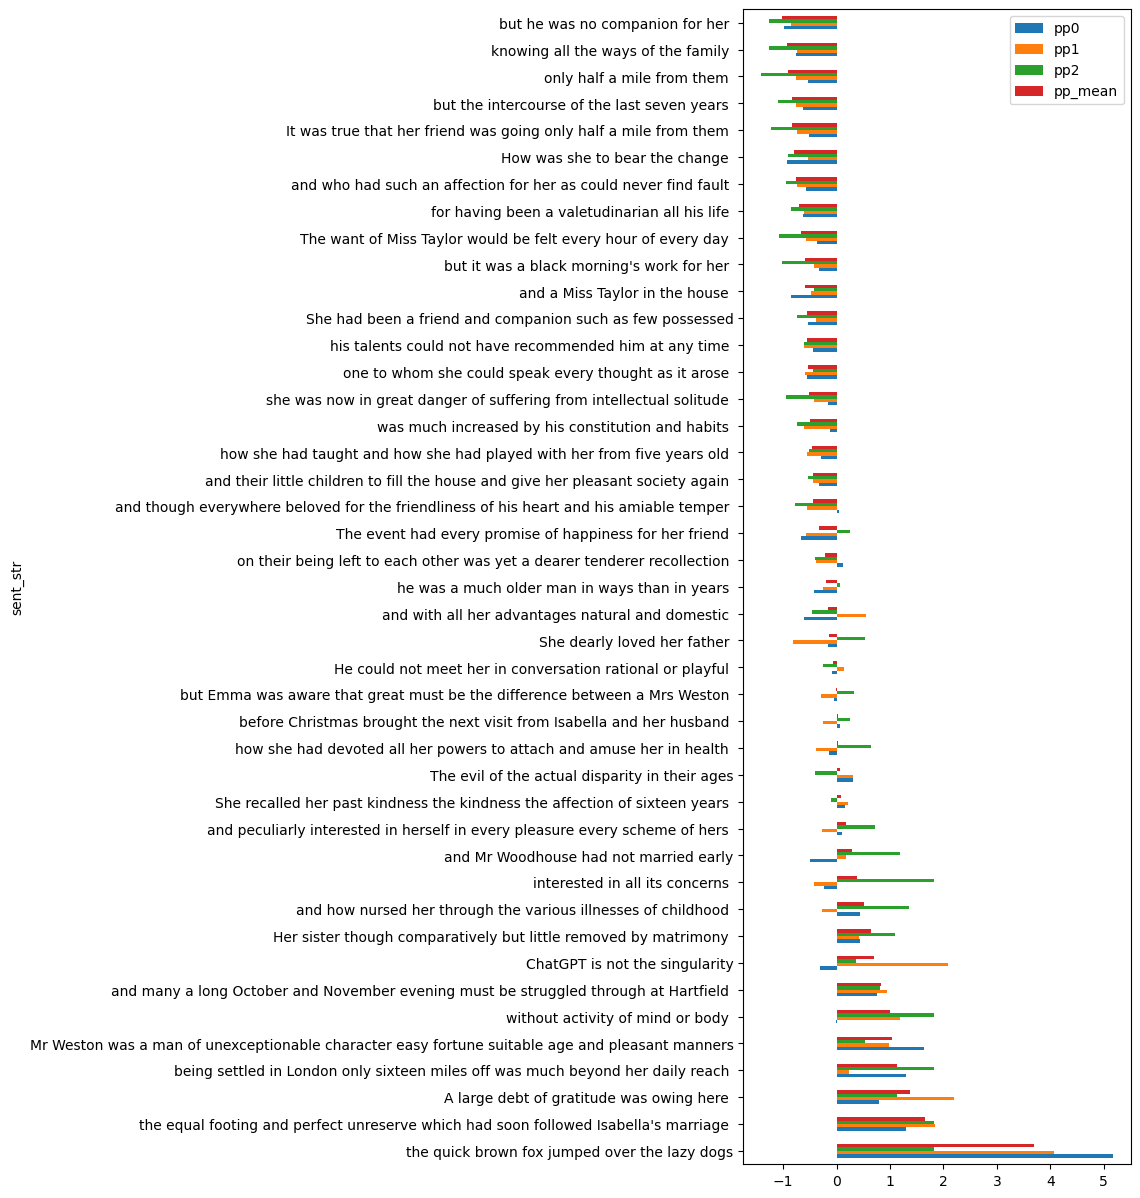

In [47]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

# Generate Text

In [48]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
    
    # Start list of words
    first_word = M[1].loc['<s>'].sample(weights='cp').index[0]
    
    words = ['<s>', first_word]
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off ...
        except KeyError as e1:
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            except KeyError as e2:
                next_word = M[0].sample(weights='p').index[0]
                
        words.append(next_word)
    
    
    text = ' '.join(words[2:])
    print('\n\n'.join([str(i+1) + ' ' + line.replace('<s>','').strip().upper() for i, line in enumerate(text.split('</s>'))]))

In [49]:
generate_text(M)

1 I ADMIRE YOUR TASTE VERY MUCH UNDER HUNG A LANDSCAPE IN COLOURED SILKS OF HER OWN CONDUCT

2 CHARLES MUSGROVE S RECOVERY MIGHT YET RECLAIM HIM

3 DOWN THE CENTRE OF THEIR FUTURE HAPPINESS IN BEING MORE HIGHLY VALUED

4 RIGHT MOMENT OCCURS

5 MRS

6 LIFE CAN DO

7 AS SHE SAT DOWN AND FOR THAT

8 HIM AND IN A VERY AGREEABLE THAT HE EVER BE ABLE TO GIVE HIS OPINION HOWEVER MADE SOME LITTLE PRESENT OF SHEWING THEM WITH SUCH TREMULOUS FEELING THE THOROUGH WANT OF SPIRIT OR LISTENED TO HER ELDEST DAUGHTER

9 DIFFERENT SITUATIONS IN LIFE AND THAT MR

10 A FEW DAYS BUT IT WOULD BE A DOUBT

11 

12 LET ME SAY IN DISSENT

13 MAY MORE THAN HAD BEEN FORMED

14 TOOK CARE TO HAVE INCREASED

15 TWO

16 I BELIEVE MRS CHARLES MUSGROVE BEGAN CONSEQUENTLY TO STAY

17 COULD DO IT

18 POCKET AND CARELESSLY SHOWING THE DIRECTION THAT IT WAS PRECISELY WHAT THEY WERE ACTUALLY SETTING FORWARD FOR UPPERCROSS WHICH MADE HIM COLD HEARTED

19 THING TO HAVE SETTLED THAT THE WORLD TO THEM

20 S PERFECTLY KNOWING T